# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5 Phase 2


---
__Name:__  *Your Name Goes Here*   
__Class:__ MIDS w261 (Section *Your Section Goes Here*, e.g., Fall 2016 Group 1)     
__Email:__  *Your UC Berkeley Email Goes Here*@iSchool.Berkeley.edu     
__StudentId__  123457    __End of StudentId__     
__Week:__   5.5

__NOTE:__ please replace `1234567` with your student id above      
__Due Time:__ HW is due the Thursday of the following week by 8AM (West coast time).

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as Altiscale's PaaS or on AWS) and is due Thursday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the Altiscale cluster and will be due Thursday of the following week by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. 

# Datasets

For Phase 2 you will first use the small datasets from phase 1 to systems test your code in the cloud. Then you will test your code on 1 file and then 20 files before running the full (191 file) Google n-gram dataset.

__Small data for systems tests__

In [1]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas-boon-systems-test.txt


In [23]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Overwriting googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


__Paths to Main data in HDFS on Altiscale__

In [1]:
import os
USER = !whoami
USER = USER[0]
OUTPUT_PATH_BASE = '/user/{USER}'.format(USER=USER)
TEST_1 = "/user/winegarj/data/1_test"
TEST_20 = "/user/winegarj/data/20_test"
FULL_DATA = "/user/winegarj/data/full" 
HDFS_DIR = "/user/root/hw51" # eg. /user/root/hw3 
HOME_DIR = os.getcwd()
USER_DIR = "/home/stassyvichev"

In [2]:
# general imports
import os
import re
import sys
from os import environ
import numpy as np
import matplotlib.pyplot as plt
PATH  = environ['PATH']
# tell matplotlib not to open a new window
%matplotlib inline

# automatically reload modules 
%reload_ext autoreload
%autoreload 2

In [3]:
# print some configuration details for future replicability.
print 'Python Version: %s' % (sys.version.split('|')[0])
hdfs_conf = !hdfs getconf -confKey fs.defaultFS ### UNCOMMENT ON DOCKER
#hdfs_conf = !hdfs getconf -confKey fs.default.name ### UNCOMMENT ON ALTISCALE
print 'HDFS filesystem running at: \n\t %s' % (hdfs_conf[0])

Python Version: 2.7.14 
HDFS filesystem running at: 
	 hdfs://nn-ia.s3s.altiscale.com:8020


In [5]:
# create an HDFS directory for this assignment
!hdfs dfs -mkdir hw52

mkdir: `hw52': File exists


In [4]:
%%javascript
$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

# Set - Up for Phase 2
Before you can run your simlarity analysis on the full Google n-gram dataset you should confirm that the code your wrote in Phase 1 works on the cloud. In the space below, copy the code for your three jobs from Phase 1 (`buildStripes.py`, `invertedIndex.py`, `similarity.py`) and rerun your  atlas-boon systems tests on Altiscale (i.e. ** the cloud**). NOTE: _you may end up modifying this code when you get to 5.7, that's fine._

### `buildStripesP2.py`

In [9]:
%%writefile buildStripesP2.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRbuildStripes(MRJob):
    SORT_VALUES = True
    
    def mapper(self, _, line):
        fields = line.lower().strip("\n").split("\t")
        words = fields[0].split(" ")
        occurrence_count = int(fields[1])
        count = 1
        for word in words:
            for i in xrange(count, len(words)):
                yield word, (words[i], occurrence_count)
                yield words[i], (word, occurrence_count)
            count += 1
    
    def reducer(self, word, occurrence_counts):
        stripe = {}
        for other_word, occurrence_count in occurrence_counts:
            stripe[other_word] = stripe.get(other_word,0)+occurrence_count
        yield word, stripe

if __name__ == '__main__':
    MRbuildStripes.run()

Overwriting buildStripesP2.py


### `invertedIndexP2.py`

In [51]:
%%writefile invertedIndexP2.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndex(MRJob):
    SORTED_VALUES = True
    JOBCONF={
#                 "mapreduce.job.reduces": "1",
                "stream.num.map.output.key.fields": 2,
                "mapreduce.job.output.key.comparator.class" : "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                "mapreduce.partition.keycomparator.options":"-k1,1 -k2,2",
                "mapred.num.key.comparator.options":"-k1,1 -k2,2",
                "mapred.text.key.comparator.options": "-k1,1 -k2,2",
                "SORT_VALUES":True
    }
    def mapper(self, _, line):
        if line:
            word,stripe = line.split("\t")
            stripe=json.loads(stripe)
            len_dict = len(stripe)
            for key, _ in stripe.items():
                yield key, (word.strip("\""), len_dict)
    
    def reducer(self, key, values):
        yield key, list(values)
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Overwriting invertedIndexP2.py


### `invertedIndexCosineP2.py`

In [37]:
%%writefile invertedIndexCosineP2.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndexCosine(MRJob):
    SORTED_VALUES = True
    JOBCONF={
#                 "mapreduce.job.reduces": "1",
                "stream.num.map.output.key.fields": 2,
                "mapreduce.job.output.key.comparator.class" : "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                "mapreduce.partition.keycomparator.options":"-k1,1 -k2,2",
                "mapred.num.key.comparator.options":"-k1,1 -k2,2",
                "mapred.text.key.comparator.options": "-k1,1 -k2,2",
                "SORT_VALUES":True
    }
    def mapper(self, _, line):
        word,stripe = line.split("\t")
        stripe=json.loads(stripe)
        stripe_length = 1/math.sqrt(len(stripe))
        for key, _ in stripe.items():
            yield key, (word.strip("\""), stripe_length)
    
    def reducer(self, key, values):
        yield key, list(values)
        
if __name__ == '__main__':
    MRinvertedIndexCosine.run() 

Overwriting invertedIndexCosineP2.py


### `similarityP2.py`

In [75]:
%%writefile similarityP2.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
import json
import math
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
import logging

class MRSimilarity(MRJob):
    SORT_VALUES = True
    
    def mapper_first(self, _, line):
        word, stripe = line.split("\t")
        stripe = json.loads(stripe)
        if len(stripe)>1:
            count = 1
            for s in stripe:
                for i in xrange(count, len(stripe)):
                    pair = sorted([s[0], stripe[i][0]])
                    yield pair, s[1]*stripe[i][1]*1.0
                count += 1
            
    
    def reducer_first(self, pair, partSims):
        partSims = list(partSims)
        sum_sims = sum(partSims)
        yield pair, sum_sims
        
    def reducer_second(self, key, value):
        yield key, list(value)
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper_first,
                reducer = self.reducer_first,
                jobconf={
                        "mapreduce.job.reduces": "2"
                }
            ),
            MRStep(
                reducer = self.reducer_second,
                jobconf={
                        "mapreduce.job.reduces": "1",
                        "stream.num.map.output.key.fields": 2,
                        "mapreduce.job.output.key.comparator.class" : "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                        "mapreduce.partition.keycomparator.options":"-k2,2nr",
                        "mapred.num.key.comparator.options":"-k2,2nr",
                        "mapred.text.key.comparator.options": "-k2,2nr",
                        "SORT_VALUES":True
                   }
            )
        ]
        
if __name__ == '__main__':
    MRSimilarity.run()

Overwriting similarityP2.py


#### atlas-boon systems test

In [79]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_buildStripes_atlas')
!hadoop fs -rm -r {OUTPUT_PATH}
!python buildStripesP2.py \
        -r hadoop atlas-boon-systems-test.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_buildStripes_atlas': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripesP2.stassyvichev.20180218.182039.429473
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/buildStripesP2.stassyvichev.20180218.182039.429473/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7653368512814253383.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  T

In [80]:
!hadoop fs -cat {OUTPUT_PATH}/*

"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}
"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}


In [81]:
INPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_buildStripes_atlas')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_invertedIndex_atlas')
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndexP2.py \
        -r hadoop hdfs://{INPUT_PATH} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_invertedIndex_atlas': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndexP2.stassyvichev.20180218.182206.889914
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/invertedIndexP2.stassyvichev.20180218.182206.889914/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4460943279738312045.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200


In [82]:
!hadoop fs -cat {OUTPUT_PATH}/*

"atlas"	[["boon", 3], ["dipped", 3]]
"boon"	[["atlas", 2], ["cava", 2], ["dipped", 3]]
"cava"	[["boon", 3], ["dipped", 3]]
"dipped"	[["atlas", 2], ["boon", 3], ["cava", 2]]


In [83]:
INPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_buildStripes_atlas')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_invertedIndexCosine_atlas')
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndexCosineP2.py \
        -r hadoop hdfs://{INPUT_PATH} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_invertedIndexCosine_atlas': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndexCosineP2.stassyvichev.20180218.182545.601918
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/invertedIndexCosineP2.stassyvichev.20180218.182545.601918/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2174230798237591381.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.

In [84]:
!hadoop fs -cat {OUTPUT_PATH}/*

"atlas"	[["boon", 0.5773502691896258], ["dipped", 0.5773502691896258]]
"boon"	[["atlas", 0.7071067811865475], ["cava", 0.7071067811865475], ["dipped", 0.5773502691896258]]
"cava"	[["boon", 0.5773502691896258], ["dipped", 0.5773502691896258]]
"dipped"	[["atlas", 0.7071067811865475], ["boon", 0.5773502691896258], ["cava", 0.7071067811865475]]


In [85]:
INPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_invertedIndexCosine_atlas')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_similarity_atlas')
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarityP2.py \
        -r hadoop hdfs://{INPUT_PATH} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_similarity_atlas': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarityP2.stassyvichev.20180218.182716.192762
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/similarityP2.stassyvichev.20180218.182716.192762/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3992860241857292754.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timelin

In [86]:
!hadoop fs -cat {OUTPUT_PATH}/*

["atlas", "cava"]	[0.9999999999999998]
["boon", "dipped"]	[0.6666666666666669]
["cava", "dipped"]	[0.408248290463863]
["boon", "cava"]	[0.408248290463863]
["atlas", "dipped"]	[0.408248290463863]
["atlas", "boon"]	[0.408248290463863]


#### 10-line systems test

In [87]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_buildStripes_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!python buildStripesP2.py \
        -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_buildStripes_10lines': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripesP2.stassyvichev.20180218.182912.496333
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/buildStripesP2.stassyvichev.20180218.182912.496333/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob523055107048727327.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  

In [88]:
!hadoop fs -cat {OUTPUT_PATH}/*

"a"	{"limited": 55, "sea": 62, "general": 92, "female": 447, "in": 1201, "religious": 59, "george": 92, "biography": 92, "city": 62, "for": 59, "tales": 123, "government": 102, "the": 124, "forms": 116, "wales": 1099, "christmas": 1099, "child's": 1099, "collection": 239, "by": 62, "case": 604, "circumstantial": 62, "of": 1011, "study": 604, "bill": 59, "establishing": 59, "narrative": 62, "fairy": 123}
"bill"	{"a": 59, "religious": 59, "for": 59, "establishing": 59}
"biography"	{"a": 92, "of": 92, "george": 92, "general": 92}
"by"	{"a": 62, "city": 62, "the": 62, "sea": 62}
"case"	{"a": 604, "limited": 55, "government": 102, "of": 502, "study": 604, "female": 447, "in": 102}
"child's"	{"a": 1099, "wales": 1099, "christmas": 1099, "in": 1099}
"christmas"	{"a": 1099, "wales": 1099, "in": 1099, "child's": 1099}
"circumstantial"	{"a": 62, "of": 62, "the": 62, "narrative": 62}
"city"	{"a": 62, "the": 62, "by": 62, "sea": 62}
"collection"	{"a": 239, "forms": 116, "fairy": 123, "tales": 123,

In [89]:
INPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_buildStripes_10lines')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_invertedIndex_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndexP2.py \
        -r hadoop hdfs://{INPUT_PATH} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_invertedIndex_10lines': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndexP2.stassyvichev.20180218.183252.021526
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/invertedIndexP2.stassyvichev.20180218.183252.021526/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5574307541778728811.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:1020

In [90]:
!hadoop fs -cat {OUTPUT_PATH}/*

"a"	[["bill", 4], ["biography", 4], ["by", 4], ["case", 7], ["child's", 4], ["christmas", 4], ["circumstantial", 4], ["city", 4], ["collection", 5], ["establishing", 4], ["fairy", 4], ["female", 4], ["for", 4], ["forms", 3], ["general", 4], ["george", 4], ["government", 4], ["in", 7], ["limited", 4], ["narrative", 4], ["of", 16], ["religious", 4], ["sea", 4], ["study", 7], ["tales", 4], ["the", 7], ["wales", 4]]
"bill"	[["a", 27], ["establishing", 4], ["for", 4], ["religious", 4]]
"biography"	[["a", 27], ["general", 4], ["george", 4], ["of", 16]]
"by"	[["a", 27], ["city", 4], ["sea", 4], ["the", 7]]
"case"	[["a", 27], ["female", 4], ["government", 4], ["in", 7], ["limited", 4], ["of", 16], ["study", 7]]
"child's"	[["a", 27], ["christmas", 4], ["in", 7], ["wales", 4]]
"christmas"	[["a", 27], ["child's", 4], ["in", 7], ["wales", 4]]
"circumstantial"	[["a", 27], ["narrative", 4], ["of", 16], ["the", 7]]
"city"	[["a", 27], ["by", 4], ["sea", 4], ["the", 7]]
"collection"	[["a", 27], ["fairy

In [91]:
INPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_buildStripes_10lines')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_invertedIndexCosine_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!python invertedIndexCosineP2.py \
        -r hadoop hdfs://{INPUT_PATH} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_invertedIndexCosine_10lines': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndexCosineP2.stassyvichev.20180218.183439.671848
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/invertedIndexCosineP2.stassyvichev.20180218.183439.671848/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2761286348187282315.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/1

In [92]:
!hadoop fs -cat {OUTPUT_PATH}/*

"a"	[["bill", 0.5], ["biography", 0.5], ["by", 0.5], ["case", 0.3779644730092272], ["child's", 0.5], ["christmas", 0.5], ["circumstantial", 0.5], ["city", 0.5], ["collection", 0.4472135954999579], ["establishing", 0.5], ["fairy", 0.5], ["female", 0.5], ["for", 0.5], ["forms", 0.5773502691896258], ["general", 0.5], ["george", 0.5], ["government", 0.5], ["in", 0.3779644730092272], ["limited", 0.5], ["narrative", 0.5], ["of", 0.25], ["religious", 0.5], ["sea", 0.5], ["study", 0.3779644730092272], ["tales", 0.5], ["the", 0.3779644730092272], ["wales", 0.5]]
"bill"	[["a", 0.19245008972987526], ["establishing", 0.5], ["for", 0.5], ["religious", 0.5]]
"biography"	[["a", 0.19245008972987526], ["general", 0.5], ["george", 0.5], ["of", 0.25]]
"by"	[["a", 0.19245008972987526], ["city", 0.5], ["sea", 0.5], ["the", 0.3779644730092272]]
"case"	[["a", 0.19245008972987526], ["female", 0.5], ["government", 0.5], ["in", 0.3779644730092272], ["limited", 0.5], ["of", 0.25], ["study", 0.3779644730092272]]


In [93]:
INPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_invertedIndexCosine_10lines')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'test_similarity_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarityP2.py \
        -r hadoop hdfs://{INPUT_PATH} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/test_similarity_10lines': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarityP2.stassyvichev.20180218.183624.340464
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/similarityP2.stassyvichev.20180218.183624.340464/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8797337477396602443.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timel

In [94]:
!hadoop fs -cat {OUTPUT_PATH}/*

["female", "limited"]	[1.0]
["forms", "tales"]	[0.8660254037844388]
["fairy", "forms"]	[0.8660254037844388]
["case", "study"]	[0.8571428571428569]
["general", "george"]	[0.75]
["female", "government"]	[0.75]
["biography", "general"]	[0.75]
["circumstantial", "narrative"]	[0.75]
["government", "limited"]	[0.75]
["establishing", "for"]	[0.75]
["bill", "establishing"]	[0.75]
["bill", "for"]	[0.75]
["bill", "religious"]	[0.75]
["biography", "george"]	[0.75]
["by", "city"]	[0.75]
["by", "sea"]	[0.75]
["child's", "christmas"]	[0.75]
["for", "religious"]	[0.75]
["child's", "wales"]	[0.75]
["christmas", "wales"]	[0.75]
["fairy", "tales"]	[0.75]
["city", "sea"]	[0.75]
["establishing", "religious"]	[0.75]
["a", "of"]	[0.7216878364870322]
["collection", "fairy"]	[0.6708203932499369]
["collection", "tales"]	[0.6708203932499369]
["forms", "narrative"]	[0.5773502691896258]
["forms", "limited"]	[0.5773502691896258]
["forms", "general"]	[0.5773502691896258]
["female", "forms"]	[0.5773502691896258]
["c

# HW5.6 -Google n-grams EDA

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.6.1 - A. Longest 5-gram (number of characters)

In [21]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re
from datetime import datetime
import sys

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):
#     SORT_VALUES = True
    def mapper(self, _, line):
        fields = line.strip("\n").split("\t")
        yield len(fields[0]), fields[0]
    
    def reducer_init(self):
        self.longest_ngrams = []
        self.longest_size = 0
        
    def reducer(self, key, values):
        if int(key)> self.longest_size:
            self.longest_size = int(key)
            self.longest_ngrams = list(values)
        elif int(key) == self.longest_size:
            self.longest_ngrams = list(self.longest_ngrams)+list(values)
            
    def reducer_final(self):
        yield self.longest_size, ";".join(list(self.longest_ngrams))
    
    def reducer_2_init(self):
        self.longest_2_ngrams = []
        self.longest_2_size = 0
    
    def reducer_2(self, key, values):
        if int(key)> self.longest_2_size:
            self.longest_2_size = int(key)
            self.longest_2_ngrams = list(values)
        elif int(key) == self.longest_2_size:
            self.longest_2_ngrams = list(self.longest_2_ngrams)+list(values)
            
    def reducer_2_final(self):
        yield self.longest_2_size, ";".join(list(self.longest_2_ngrams))
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                reducer_init = self.reducer_init,
                reducer_final = self.reducer_final,
                reducer = self.reducer,
                jobconf={
                    "mapreduce.job.reduces": "16",
                    "stream.num.map.output.key.fields": 1,
                    "mapreduce.job.output.key.comparator.class" : "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k1,1nr",
                }
            ),
            MRStep(
                reducer_init = self.reducer_2_init,
                reducer_final = self.reducer_2_final,
                reducer = self.reducer_2,
                jobconf={
                    "mapreduce.job.reduces": "1"
                }
            )
        ]
    
if __name__ == '__main__':
    start_time = datetime.now()
    longest5gram.run()
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    sys.stderr.write(str(elapsed_time))

Overwriting longest5gram.py


__On test data set:__

In [16]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_ngram_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/02/21 20:36:44 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/longest_ngram_10lines' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.stassyvichev.20180221.203645.667279
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/longest5gram.stassyvichev.20180221.203645.667279/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1831596753951981602.jar tmpDir=null
  Timeline service addre

In [17]:
!hadoop fs -cat {OUTPUT_PATH}/*

33	"A Circumstantial Narrative of the;A BILL FOR ESTABLISHING RELIGIOUS"


In [101]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_ngram_test1')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop hdfs://{TEST_1} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/longest_ngram_test1': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.stassyvichev.20180218.184535.481553
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/longest5gram.stassyvichev.20180218.184535.481553/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob397020653309401954.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline s

In [102]:
!hadoop fs -cat {OUTPUT_PATH}/*

58	"Interpersonal Communication Interpersonal communication is;Hydroxytryptamine stimulates inositol phosphate production"


__ On the 20 files dataset: __

In [18]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_ngram_test20')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop hdfs://{TEST_20} \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/02/21 20:39:06 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/longest_ngram_test20' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.stassyvichev.20180221.203907.139425
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/longest5gram.stassyvichev.20180221.203907.139425/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6398353053558422401.jar tmpDir=null
  Timeline service addres

In [19]:
!hadoop fs -cat {OUTPUT_PATH}/*

83	"EngineeringGraphic Design Applied SciencesPsychology InteriorDesignBiologyChemistry"


__On full data set:__

In [25]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_full')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop hdfs://{FULL_DATA} \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/02/21 21:19:14 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/longest_full' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.stassyvichev.20180221.211915.618948
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/longest5gram.stassyvichev.20180221.211915.618948/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3706209577258186462.jar tmpDir=null
  Timeline service address: http:

Removing temp directory /tmp/longest5gram.stassyvichev.20180221.211915.618948...
0:03:06.819524
real	3m6.911s
user	0m46.510s
sys	0m2.263s


In [23]:
!hadoop fs -cat {OUTPUT_PATH}/*

159	"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR;ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"


### Longest 5grams MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15

__Step 1:__  

    RUNNING for 107.0s ~= 2 minutes  
    Reduce tasks = 16 
    
__Step 2:__   

    RUNNING for 108.8s ~= 2 minutes
    Reduce tasks = 1  

### HW5.6.1 - B. Top 10 most frequent words 

In [36]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):
 
    def mapper(self, _, line):
        fields = line.strip("\n").split("\t")
        count = int(fields[1])
        for word in fields[0].split(" "):
            yield word.lower(), count
    
    def reducer(self, key, values):
        yield key, sum(values)
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Writing mostFrequentWords.py


__On the test data set:__

__ On the 20 files dataset: __

__On the full data set:__

### Most frequent words MR stats
    
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__   

    RUNNING for 590.7s ~= 10 minutes   
    Launched map tasks=191  
    Launched reduce tasks=57   

__Step 2:__  

    RUNNING for 76.6s   
    Launched map tasks=110
    Launched reduce tasks=16  


### HW5.6.1 - C. 20 Most/Least densely appearing words 

In [ ]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.6.1.C
    
    # END STUDENT CODE 5.6.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

__On the test data set:__

__ On the 20 files dataset: __

__On the full data set:__

### Word density MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__ 

    RUNNING for 649.2s  ~= 10 minutes      
    Launched map tasks=190   
    Launched reduce tasks=57     

__Step 2:__  

    RUNNING for 74.4s  ~= 1 minute    
    Launched map tasks=110   
    Launched reduce tasks=20   

### HW5.6.1 - D. Distribution of 5-gram sizes (character length)

D. Distribution of 5-gram sizes (character length). E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

#### TODO: see below

In [135]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):
    
    #### TODO: divide the counts by 1000s to make the graph more readable
    #### TODO: split the lengths into buckets <10, <25, <50, <75, <100
    def mapper(self, _, line):
        fields = line.strip("\n").split("\t")
        yield len(fields[0]), int(fields[1])
    
    def combiner(self,length, counts):
        yield length, sum(counts)
        
    def reducer(self,length, counts):
        yield length, sum(counts)
    
    def reducer_sort(self, key, values):
        yield key, list(values)[0]
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                combiner = self.combiner,
                reducer = self.reducer,
                jobconf = {
                    "mapreduce.job.reduces": "8",
                }
            ),
            MRStep(
                reducer = self.reducer_sort,
                jobconf = {
                    "SORT_VALUES":True,
                    "mapreduce.job.reduces": "1",
                    "stream.num.map.output.key.fields": 1,
                    "mapreduce.job.output.key.comparator.class" : "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k1,1nr",
                }
            )
        ]
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


__On the test data set:__

In [26]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python distribution.py \
        -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/02/21 21:40:27 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/distributions_10lines' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.stassyvichev.20180221.214028.180124
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/distribution.stassyvichev.20180221.214028.180124/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8930436528154988463.jar tmpDir=null
  Timeline service addre

In [28]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_10lines.txt

In [27]:
!hadoop fs -cat {OUTPUT_PATH}/*

33	121
29	92
28	1099
27	123
26	102
24	116
23	55
22	447
17	62


In [124]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_1file')
!hadoop fs -rm -r {OUTPUT_PATH}
!python distribution.py \
        -r hadoop hdfs://{TEST_1} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/distributions_1file': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.stassyvichev.20180218.192929.539189
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/distribution.stassyvichev.20180218.192929.539189/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4917966297621260976.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline 

In [125]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_1file.txt

__ On the 20 files dataset: __

In [29]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_20files')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python distribution.py \
        -r hadoop hdfs://{TEST_20} \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/02/21 21:42:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/distributions_20files' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.stassyvichev.20180221.214221.861956
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/distribution.stassyvichev.20180221.214221.861956/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2672183610124026940.jar tmpDir=null
  Timeline service addre

In [133]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_20files.txt

__On the full data set:__

In [31]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_full')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python distribution.py \
        -r hadoop hdfs://{FULL_DATA} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/stassyvichev/distributions_full': No such file or directory
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.stassyvichev.20180221.230828.129762
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/distribution.stassyvichev.20180221.230828.129762/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7297586179516158926.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline s

Removing temp directory /tmp/distribution.stassyvichev.20180221.230828.129762...

real	2m35.994s
user	0m48.654s
sys	0m2.282s


In [32]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_full.txt

### Distribution MRJob stats

__Step 1:__ 

    RUNNING for 157.8s ~= 2.6 minutes  
    Launched map tasks=191  
    Launched reduce tasks=16   
    
__Step 2:__  

    RUNNING for 115.0s ~= 2 minutes   
    Launched map tasks=139
	Launched reduce tasks=1  

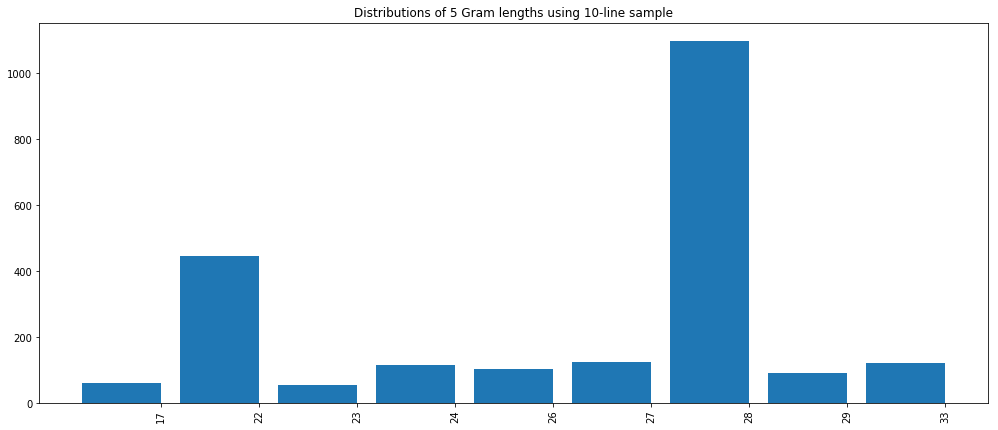

In [128]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_10lines.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using 10-line sample")
pl.show()

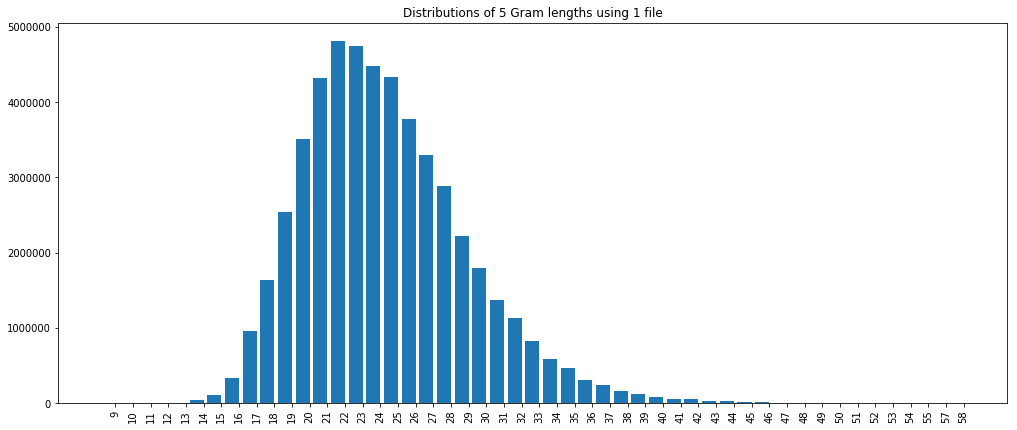

In [129]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_1file.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using 1 file")
pl.show()

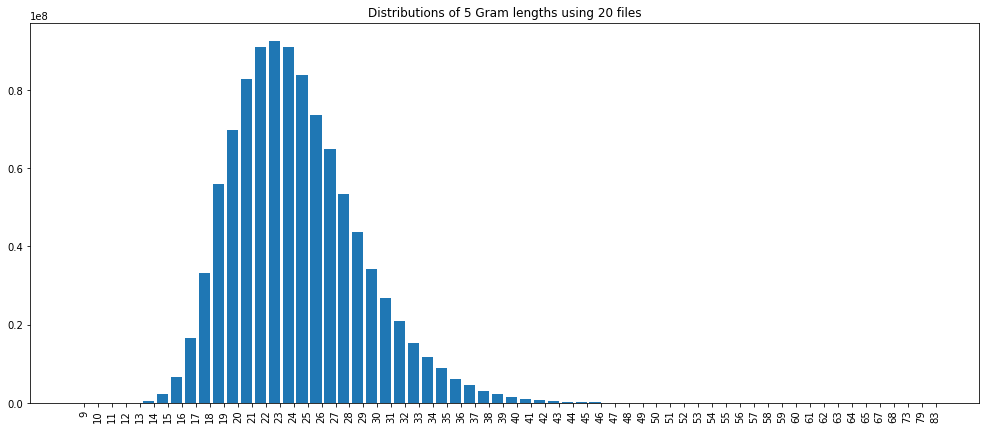

In [134]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_20files.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using 20 files")
pl.show()

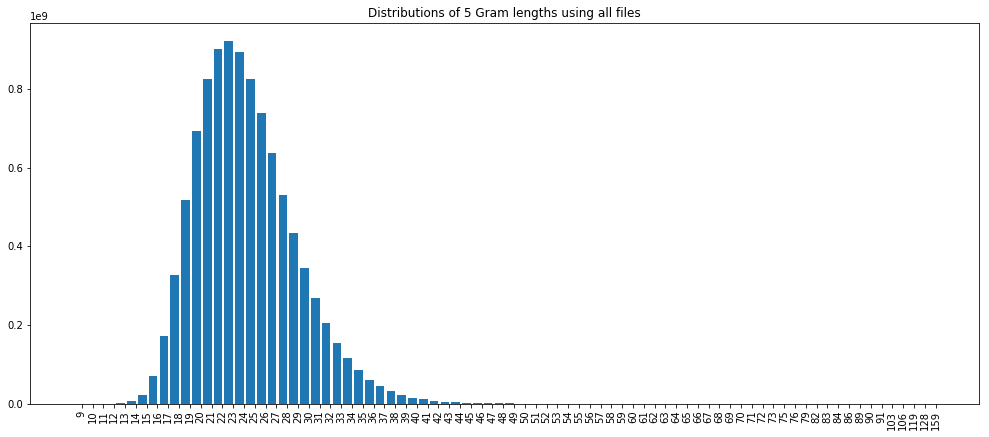

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_full.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using all files")
pl.show()

### HW5.6.2 - OPTIONAL: log-log plots (PHASE 2)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

# HW5.7 - Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3-5 plus some preprocessing)   

For the remainder of this assignment please feel free to eliminate stop words from your analysis (see stopWords in the cell below)

__A large subset of the Google n-grams dataset as was described above__

For each HW 5.6 - 5.7.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.


For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

In [ ]:
stopwords =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 's', 't', 'can', 'will', 'just', 
              'don', 'should', 'now']

### HW5.7.1 Running on 1 file

In [ ]:
# ADD CELLS AS NEEDED

### HW5.7.2 Running on 20 test files

In [ ]:
# ADD CELLS AS NEEDED

### HW5.7.3 Running the full dataset on Altiscale

Please contact the TAs for approval after obtaining results from 5.7.2. We have ran into issues in the past where the clusters froze because people did not test their code on a smaller dataset.

In [ ]:
# ADD CELLS AS NEEDED

#### Pretty print results
NOTE: depending on how you processed the stop words your results may differ from the table provided. 

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )


In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

# HW5.8 - Evaluation of synonyms that your discovered

In this part of the assignment you will evaluate the success of you synonym detector. Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.7, and use the synonyms function from the wordnet synonnyms list from the nltk package (see provided code below).

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [ ]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("sims2/top1000sims","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

# HW5.9 - OPTIONAL: using different vocabulary subsets

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

# HW5.10  - OPTIONAL 

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

# HW5.11 - OPTIONAL 

Once again, benchmark your top 10,000 associations (as in 5.7), this time for your
results from 5.8. Has your detector improved?